# Prediction of Stock Market Evolutions with Financial News



## [StockPredictionsWithFinancialNews]((https://github.com/altogi/StockPredictionsWithFinancialNews): About the Project

In the stock market, information is money. Receiving the information first gives one a significant advantage over other traders.
Thus, it makes sense that financial news have a great influence over the market.

Given the recent rise in the availability of data, and the apparition of revolutionary NLP techniques, it has been attempted in many occasions to predict market trends based on financial news. The majority of the existing solutions rely on sentiment analysis, assuming that a positive document sentiment is directly related to increases in a security's price, and viceversa. Sentiment is either extracted using a predefined dictionary of tagged words, or by applying deep learning techniques that rely on a large datasets of labeled news. An advanced example of rule-based sentiment analysis is [VADER](https://blog.quantinsti.com/vader-sentiment/), a model that is sensitive not only to polarity, but also to a document's intensity.

With the recent dawn of the Transformer, it is now possible to extract the sentiment from a document in a much quicker non-sequential procedure, and with the usage of pre-trained models such as BERT, applying these models to a desired use case has never been simpler. An example of this is [FinBERT](https://arxiv.org/abs/1908.10063), a text classifier predicting sentiment with a fine-tuned version of BERT.

Nevertheless, sentiment can act as an intermediate factor between the news, and the stock's price. As a result, developing a text classifier to predict sentiment is not as efficient as directly predicting price evolutions, when the objective is to develop a profitable trading strategy.

This work has implemented a text classifier based on BERT, fine-tuned with a dataset of financial news, and trained in order to predict whether a stock's price will rise or fall. As opposed to FinBERT, sentiment is not taken into account. Instead, a set of criteria based on the price evolutions close to the release date of every news article have been applied, in order to label the dataset with which BERT is fine-tuned. Moreover, this work has been developed based on a much more extensive dataset than the one used for FinBERT, thus further capturing the uncertainties of the market. In consequence, it is possible to profitably manage a portfolio relying exclusively on this text classifier, without complementing it with other trading strategies, as many sentiment-based trading applications do.

This notebook serves as a demo of project [StockPredictionsWithFinancialNews](https://github.com/altogi/StockPredictionsWithFinancialNews). From Kaggle's [Historical financial news archive](https://www.kaggle.com/gennadiyr/us-equities-news-data), a dataset of financial news is obtained. After a brief exploratory data analysis of it, all of the steps of the application are carried out.

## 1. Environment Set-Up

In [2]:
#Install all required libraries
! pip install findspark
! pip install IPython
! pip install pandas
! pip install matplotlib
! pip install requests
! pip install yfinance
! pip install ktrain

     |████████████████████████████████| 6.3MB 7.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=4e9803f83919e37a5bfbba486eab92b3e8c74f4f2a0066a7c1f002a073773680
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 25.3MB 1.3MB/s 
     |████████████████████████████████| 6.8MB 36.6MB/s 
     |████████████████████████████████| 983kB 39.3MB/s 
     |████████████████████████████████| 266kB 17.9MB/s 
     |████████████████████████████████| 1.9MB 34.4MB/s 
     |████████████████████████████████| 1.2MB 45.7MB/s 
     |████████████████████████████████| 471kB 45.6MB/s 
     |████████████████████████████████| 901kB 46.1MB/s 
     |████████████████████████████████| 3.3MB 38.8MB/s 
  Created wheel for ktrain: filena

In [55]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef
from main import FinancialNewsPredictor

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Exploratory Data Analysis

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Natural Language Processing/Group Assignment/us_equities_news_dataset.csv", 
                        parse_dates=['release_date']
                        )\
                        .dropna()

In [6]:
df.head(5)

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO Are Flying High Today,news,What s happening\nShares of Chinese electric car maker NIO NYSE NIO were sharply higher on Wednesday morning after a Chinese business news outlet reported that the cash strapped company had secured new financing from a major automaker As of 12 p m EST NIO s American depositary shares ADS were up about 16 from Tuesday s closing price \nSo what\nAccording to a report from Chinese business news site Sina Finance that cites a person familiar with the matter NIO will soon receive a cash infusion of about 1 billion from Guangzhou based GAC Group OTC GNZUF At press time neither NIO nor GAC had confirmed or denied the report \n\nGAC is one of China s big domestic automakers It has significant joint ventures with Honda Motor and Fiat Chrysler Automobiles among others If GAC has in fact decided to make a major investment in NIO and as of now neither company has confirmed the report then NIO s future is bright \nThat s an important development In its 15 months as a public company NIO has seen rising sales and strong customer loyalty but its rapidly declining cash has called its future into question As of Sept 30 the company had just 274 3 million remaining down from 1 123 billion on March 31 \nNow what\nIf this report is accurate and if the deal closes then it s extremely bullish for NIO but I think that auto investors should tread a bit carefully here Note that an earlier bailout deal fell through at the last minute because of concerns about the company s viability Use caution with this one,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group among losers,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingredients NASDAQ MGPI 24 Workhorse Group NASDAQ WKHS 9 China XD Plastics NASDAQ CXDC 6,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Mattel among losers,news,Gainers NIO NYSE NIO 14 Village Farms International NASDAQ VFF 14 Purple Innovation NASDAQ PRPL 7 KBS Fashion NASDAQ KBSF 7 New Age Beverages NASDAQ NBEV 6 \nLosers CTI Industries NASDAQ CTIB 13 Dogness International NASDAQ DOGZ 5 Calyxt NASDAQ CLXT 7 Mattel NASDAQ MAT 6 Beyond Meat NASDAQ BYND 6,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \nFluent NASDAQ FLNT 36 after raising preliminary financials \nOrganiGram Holdings NASDAQ OGI 24 after Q4 results \nClovis Oncology NASDAQ CLVS 22 as FDA accepts Clovis application for new use of Rubraca \nMomenta Pharmaceuticals NASDAQ MNTA 15 on positive analyst upgrade \nRockwell Medical NASDAQ RMTI 12 on Triferic deal in India \nNeovasc NASDAQ NVCN 11 as FDA accepts Neovasc s Reducer application \nNIO NYSE NIO 11 on hopes for funding secured \nOncolytics Biotech NASDAQ ONCY 11 \nNovavax NASDAQ NVAX 8 as NanoFlu Fast Track d in U S \nTRACON Pharmaceuticals NASDAQ TCON 7 \nPG E NYSE PCG 6 after Citigroup calls agreement big step forward \nDURECT NASDAQ DRRX 5,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharma deal \nTown Sports International Holdings NASDAQ CLUB 30 \nPulmatrix NASDAQ PULM 15 on research collaboration with Nocion Therapeutics to explore new technologies to enable and improve inhaled drug delivery \nPlus Therapeutics NASDAQ PSTV 14 on shareholder update \nNIO NYSE NIO 11 on robust December delivery update \nProtalix BioTherapeutics NYSEMKT PLX 10 \nInspireMD NYSEMKT NSPR 10 on strong preliminary 4Q19 revenue and reports inducement award under NYSE guide 711 a \nCamber Energy NYSEMKT CEI 10 on regaining compliance with NYSE \nCellectar Biosciences NASDAQ CLRB 11 on orphan drug tag for CLR 131 in LPL \nSmileDirectClub NASDAQ SDC 8 on Walmart deal \nFuelCell Energy

From this preview, it is clear that the dataset employed here perfectly follows the format required by the application. More specifically, this dataset contains:
* An identification column **id**, representing every news article.
* A column **content** containing the article's text.
* A field **ticker** with the stock ticker of the company mentioned in the article.
* A column **release_date** with the date in which the article came out. 

### 2.1 Converting release_date to DateTime
Although this is automatically done by the application, it is useful for the EDA.

In [7]:
df['release_date'] = pd.to_datetime(df['release_date'])

### 2.2 How many unique values are there for ticker, category, and provider?

In [8]:
print("Checking amount of distinct values in columns ticker, category, and provider:")
df[['ticker', 'category', 'provider']].nunique()

Checking amount of distinct values in columns ticker, category, and provider:


ticker      802
category      2
provider    979
dtype: int64

### 2.3 How many missing values are there in the whole dataset?
In case null values are found in columns 'id', 'ticker', 'content', or 'release_date', it would be necessary to scrap the rows with null values.

In [9]:
print("Checking amount of null values in the whole dataset:")
df.isna().sum(axis=0)

Checking amount of null values in the whole dataset:


id              0
ticker          0
title           0
category        0
content         0
release_date    0
provider        0
url             0
article_id      0
dtype: int64

### 2.4 What is the temporal extent of the dataset?

In [10]:
min_date = df['release_date'].min()
max_date = df['release_date'].max()
print(f'The dataset extends from {min_date} to {max_date}, with {len(df)} entries.')

The dataset extends from 2008-10-02 00:00:00 to 2020-02-13 00:00:00, with 221505 entries.


In this case, one can see that the dataset is fairly large. This will be convenient for training.

### 2.5 What are the 20 most mentioned tickers?

In [11]:
df.groupby(by='ticker').count().sort_values(by='title', ascending=False)[['title']].head(20)

,title
ticker,
AAPL,20231
MSFT,8110
BAC,7408
AMZN,6330
NWSA,5914
BA,5879
GOOGL,5171
GS,4513
TSLA,4283


Around a 10% of the dataset contains news regarding Apple! The rest of this podium is mainly filled with big tech companies.

### 2.6 What is the distribution of the article length?

In [12]:
df['content'].apply(lambda x: len(x)).describe()

count    221505.000000
mean       3491.601187
std        3077.243286
min           3.000000
25%        1957.000000
50%        3054.000000
75%        4399.000000
max      140262.000000
Name: content, dtype: float64

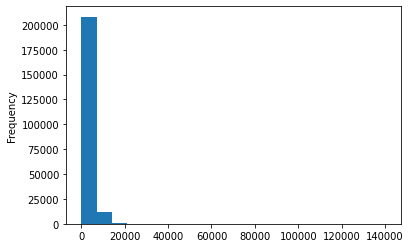

In [13]:
df['content'].apply(lambda x: len(x)).plot.hist(bins=20)
plt.show()

The distribution of the number of characters in every article is significantly right-skewed, with a mean around 3500 characters. The maximum article length is also very significant. 

In [14]:
df['content'].apply(lambda x: len(x.split(' '))).describe()

count    221505.000000
mean        689.325631
std         599.451036
min           1.000000
25%         386.000000
50%         603.000000
75%         864.000000
max       27353.000000
Name: content, dtype: float64

If we look at the number of words in every article, we see a fairly large mean (almost 700). This is well above the maximum sequence length accepted by BERT (512). In any case, the application will trim every article that is longer than the specified maximum sequence length.

## 3. Importing Market Data for each Ticker

### 3.1 Letting the application do its thing.

Let's begin the processing of this dataset using the application. To make sure all results will be adequately saved, a Google Drive directory is set as `base_directory`. Moreover, only a certainn set of sectors are selected to filter out the rest.

In [68]:
f = FinancialNewsPredictor(df, 
                           base_directory='/content/drive/MyDrive/Natural Language Processing/Group Assignment/',
                           selection=['Technology', 'Financial Services', 'Consumer Cyclical', 'Communication Services'],
                           selection_mode='sector')

Now, market data is downloaded with `f.import_financial_data()`, for the following days after the news release date: 1, 2, 3, 4, 5, 6, 7, 10 and 14.

In [69]:
f.import_financial_data(deltas=[1, 2, 3, 4, 5, 6, 7, 10, 14])

### 3.2 How many different sectors and industries are there in the dataset?

Let's see what is the sector distribution of the initial (unfilitered) dataset. Note that the specified selections are only implemented a few steps later.

In [70]:
f.market_data.groupby(by='sector').count().sort_values(by='ticker', ascending=False)[['ticker']]

,ticker
sector,
Technology,47587
Financial Services,33683
Consumer Cyclical,30361
Industrials,22356
Communication Services,17988
Consumer Defensive,13624
Healthcare,13568
Energy,10902
Basic Materials,6608


In [71]:
f.market_data.groupby(by='industry').count().sort_values(by='ticker', ascending=False)[['ticker']].head(10)

,ticker
industry,
Consumer Electronics,19824
Banks—Diversified,13212
Software—Infrastructure,9873
Auto Manufacturers,8817
Entertainment,7937
Semiconductors,7770
Aerospace & Defense,7502
Capital Markets,7214
Internet Retail,6410


Whereas news are more or less homogeneously distributed among sectors (Technology, Financial Services, Consumer Cyclical), the multiple industries are not as well spread out, a big chunk of the news belonging to Consumer Electronics or Banks.

### 3.3 How many missing prices are there in the dataset?

In [72]:
f.market_data.isna().sum(axis=0)

Unnamed: 0        0
id                0
ticker            0
date_base         0
date_+1           0
date_+2           0
date_+3           0
date_+4           0
date_+5           0
date_+6           0
date_+7           0
date_+10          0
date_+14          0
sector          212
industry        212
close_base        0
open_base         0
close_+1       2650
close_+2       6122
close_+3       9785
close_+4      10110
close_+5      10098
close_+6      11214
close_+7       7889
close_+10     10092
close_+14      8688
dtype: int64

Although there is a significant amount of missing prices. These rows will be dropped later on, since they correspond to companies not represented by the Yahoo Finance API.

## 4. Labeling Financial News According to Price Evolutions

In [73]:
f.apply_selection()
f.label_financial_data(method='MA', delta_to_examine=[5,6,7], threshold=0.01)

Class Distribution
    Financial News Labeled with "sell": 14331 (14.87%)
    Financial News Labeled with "buy": 17777 (18.45%)
    Financial News Labeled with "do_nothing": 64241 (66.68%)
14331 + 17777 + 64241 = 96349=96349


For the selected method, which compares the average of the whole week after the news release date with the average of the last three days of such week, only 32% of the dataset corresponds to news in which it is adviseable to enter the market according to the implemented method. It would be interesting to try with different thresholds or criteria, to see how class homogeneity reacts.

## 5. Training a Text Classifier to Predict Price Evolutions

Now, let's use ktrain to define a text classifier to predict the market actions associated to each financial news. Although a lighter, distilled version of BERT is used (`model = 'distilbert'`), the maximum sequence length and the batch size have not been maximized.

Given that the mean sequence length in the dataset is close to 600, it was first attempted to employ `max_len=512` (the maximum value for BERT). However, this resulted in very long training times, due to the large dataset (around 40 hours per epoch, even with DistilBERT). Therefore, assuming that in most news articles, most of the relevant information is presented at the beginning of the article, `max_len`was reduced to 256. Based on this selection, a batch size close to 10 works well on Google Colab's GPU.


In [74]:
f.create_classifier(model='distilbert', max_len=256, batch_size=10, split_type='random')

In [75]:
f.train_classifier(epochs=10, early_stopping=3)

## 6. Predicting and Simulating with the Model

### 6.1 Prediction

In [76]:
f.predict_with_classifier()

### 6.2 What is the resulting confusion matrix for the validation set?

In [77]:
y_true = f.predictions.loc[f.predictions['is_validation'] == 1,['buy', 'sell', 'do_nothing']].apply(lambda row: 'buy' if row[0] == 1 else ('sell' if row[1] == 1 else 'do_nothing'), axis=1)
y_pred = f.predictions.loc[f.predictions['is_validation'] == 1, 'prediction']
conf_mat = pd.DataFrame(
      data=confusion_matrix(
          y_true, 
          y_pred, 
          labels=['buy', 'sell', 'do_nothing'],
          normalize='true'), 
      index=['True = buy', 'True = sell', 'True = do_nothing'],
      columns=['Predicted = buy [%]', 'Predicted = sell [%]', 'Predicted = do_nothing [%]']) * 100
conf_mat['Total per Class'] = y_true\
                          .value_counts()\
                          .rename(
                              index={label: 'True = ' + label for label in ['buy', 'sell', 'do_nothing']})
conf_mat

,Predicted = buy [%],Predicted = sell [%],Predicted = do_nothing [%],Total per Class
True = buy,5.680540,26.602925,67.716535,3556
True = sell,3.907886,41.800419,54.291696,2866
True = do_nothing,1.564446,33.297011,65.138543,12848


Notes on these results:
* As we have seen, there is a slight class inbalance in the original dataset, since most of the news (66.7 %) are labeled with 'do_nothing'. 
* As a consequence, the model has a greater tendency to label news with 'do_nothing', although their true class is another one. 
    * For news with a true 'buy' label in the validation set, 67.7 % are predicted to belong to 'do_nothing', whereas only 5.7 % are predicted with their actual class.
    * For news with a true 'sell' label in the validation set, 54.3 % are predicted to belong to 'do_nothing', whereas 41.8 % are predicted with their actual class.
* Curiously, the model is able to detect occasions to sell with greater sensitivity than occasions to buy (41.8 % versus 5.7 %), even when the original dataset has more cases labeled with 'buy'.

### 6.3 What are the resulting Accuracy, F1 Score, and Matthew's Correlation Coefficient?

Given that the classes are unbalanced, it seems convenient to use MCC to counter-examine the accuracy and the F1 scores.

In [78]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, labels=['buy', 'sell', 'do_nothing'], average='micro')
mcc = matthews_corrcoef(y_true, y_pred)
print(f'Accuracy = {acc:.3f}, F1 Score = {f1:.3f}, MCC = {mcc:.3f}')

Accuracy = 0.507, F1 Score = 0.507, MCC = 0.053


It is very likely that the model's tendency to label news with 'do_nothing', and the majority of these news may artificially increase the accuracy and the F1 scores, as the MCC shows that the model is not performing as well when class imbalances are taken into account. Further work has to be carried out to improve this metric, in particular:
* Examining different labeling criteria based on the prices close to the news release date.
* Testing different hyperparameter combinations for the model's training (perhaps a larger `max_len` will capture more information of every article at a sustainable increase in computation time.
* Testing with other models. NBSVM or Bidirectional GRU are good alternatives. 

### 6.3 Simulating a Model-Managed Portfolio

Another way of evaluating the model involves seeing how a portfolio completely managed by it would perform in the market. Let's focus on a relatively uneventful series of years, for a couple of the most mentioned companies in the dataset. 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


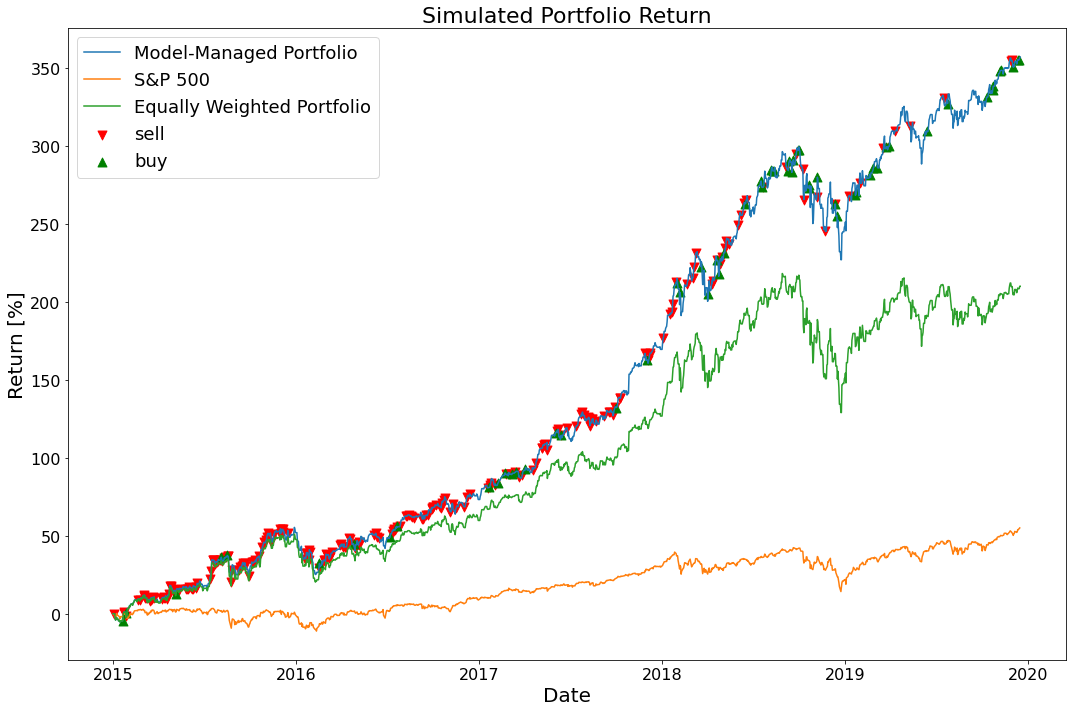

In [79]:
f.simulate_portfolio(starting_amount=1000, 
                     start_date='2015-01-01', 
                     end_date='2020-01-01', 
                     selection=['AAPL', 'MSFT', 'BAC', 'AMZN', 'NWSA', 'BA', 'GOOGL', 'GS', 'NFLX', 'TSLA', 'TGT'],
                     only_validation=True
                     )

In [80]:
selection = ['AAPL', 'MSFT', 'BAC', 'AMZN', 'NWSA', 'BA', 'GOOGL', 'GS', 'NFLX', 'TSLA', 'TGT']
columns_to_compare = ['Quantity_' + tick for tick in selection] + ['Cash', 'Total']
f.simulated_portfolio.iloc[[0, len(f.simulated_portfolio) - 1], :][columns_to_compare]

,Quantity_AAPL,Quantity_MSFT,Quantity_BAC,Quantity_AMZN,Quantity_NWSA,Quantity_BA,Quantity_GOOGL,Quantity_GS,Quantity_NFLX,Quantity_TSLA,Quantity_TGT,Cash,Total
Date,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1.000000e+03,1.440053e+06
2019-12-17 00:00:00+00:00,578,860,771,948,991,1000,952,784,1033,1189,1000,2.359928e+06,6.583794e+06


Apparently, based on the news it has received, the model sells from its Apple, Goldman Sachs, and Bank of America stocks, and makes the effort to buy Netflix and Tesla stocks. With the increase in cash from the sales and the growth in price of Tesla and Netflix, the portfolio's value increases very significantly. Note that the resulting portfolio is 75% more profitable than holding the initial portfolio during the whole time period!